## Calculate balanced machine learning measures, Without UPDRS, All 6 analyses

From request [Run ML Without the UPDRS](https://trello.com/c/Oba5eP8Y)

Weighted accuracy, ppv, npv, specificity, and sensitivity [See Sample Calculated Metrics](Machine_Learning_Metric_Calc.xlsx)

## Imports and Function Definitions

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import itertools

from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_recall_fscore_support, roc_curve, make_scorer, accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold, cross_val_score, KFold, train_test_split, LeaveOneOut, GridSearchCV, cross_validate
from sklearn.svm import SVC

from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline

def plot_confusion_matrix(cm, classes=[0,1],
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

def grid_search_optimization(model, tuned_parameters, X, y, Xh, yh, cv=5, scoring='accuracy', verbose=False):
    print("# Tuning hyper-parameters for %s" %scoring)
    print()

    clf = GridSearchCV(model, tuned_parameters, cv=cv, n_jobs = -1, scoring=scoring, verbose=1)
    clf.fit(X, y)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    if verbose:
        print("Grid scores on development set:")
        print()
        means = clf.cv_results_['mean_test_score']
        stds = clf.cv_results_['std_test_score']
        for mean, std, params in zip(means, stds, clf.cv_results_['params']):
            print("%0.3f (+/-%0.03f) for %r"
                  % (mean, std * 2, params))
        print()

    print("Detailed classification report (holdout):")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = yh, clf.predict(Xh)
    print(classification_report(y_true, y_pred))
    print()
    plot_confusion_matrix(confusion_matrix(y_true, y_pred)) 
    print()
    get_metrics(clf.best_estimator_, Xh, yh)
    
    return clf

def group_classes(data, grouping):
        classes_to_keep = grouping.keys()
        data_to_keep = data.loc[data['GroupID'].isin(classes_to_keep)]
        classes_to_change = {k:grouping[k] for k in classes_to_keep if k!= grouping[k]}
        return data_to_keep.replace(classes_to_change)
    
def plot_coefficients(classifier, feature_names, top_features=20):
     coef = classifier.coef_.ravel()
     top_positive_coefficients = np.argsort(coef)[-top_features:]
     top_negative_coefficients = np.argsort(coef)[:top_features]
     top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
     # create plot
     plt.figure(figsize=(15, 5))
     colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
     plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
     feature_names = np.array(feature_names)
     plt.xticks(np.arange(1, 1 + 2 * top_features), feature_names[top_coefficients], rotation=60, ha='right')
     plt.show()
        
def print_feature_importance(feature_names, coefs):
    assert len(feature_names) == len(coefs), "Arrays have difference lengths. Something went wrong"
    for feature, coef in zip(feature_names, coefs):
        print("%s\t%s" %(feature, coef))
        
# AKA True Negative Rate
def specificity(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    return cm[0,0] / cm[0,:].sum()

def negative_predictive_value(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    return cm[0,0] / cm[:,0].sum()

def get_weighted_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn = cm[0,0]
    tp = cm[1,1]
    fp = cm[0,1]
    fn = cm[1,0]
    
    tnw = tn / (tn + fp)
    tpw = tp / (tp + fn)
    fpw = fp / (tn + fp)
    fnw = fn / (tp + fn)
    
    return tpw, fpw, fnw, tnw

def weighted_accuracy(y_true, y_pred):
    tpw, fpw, fnw, tnw = get_weighted_confusion_matrix(y_true, y_pred)
    
    return (tpw + tnw) / (tpw + fpw + fnw + tnw)
    
def weighted_sensitivity(y_true, y_pred):
    tpw, fpw, fnw, tnw = get_weighted_confusion_matrix(y_true, y_pred)

    return tpw / (tpw + fnw)
    
def weighted_specificity(y_true, y_pred):
    tpw, fpw, fnw, tnw = get_weighted_confusion_matrix(y_true, y_pred)

    return tnw / (tnw + fpw)
    
def weighted_ppv(y_true, y_pred):
    tpw, fpw, fnw, tnw = get_weighted_confusion_matrix(y_true, y_pred)
    
    return tpw / (tpw + fpw)

def weighted_npv(y_true, y_pred):
    tpw, fpw, fnw, tnw = get_weighted_confusion_matrix(y_true, y_pred)
    
    return tnw / (tnw + fnw)

def plot_roc(model, X_test, Y_test):
    y_true, y_pred = Y_test, model.predict(X_test)
    print(classification_report(y_true, y_pred))

    y_pred_prob = model.predict_proba(X_test)[:,1]

    fpr, tpr, thresholds = roc_curve(Y_test, y_pred_prob)

    plt.plot([0,1],[0,1], 'k--')
    plt.plot(fpr, tpr, label='Linear SVC')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Linear SVC ROC Curve')
    plt.show()
    
    for a,b in zip(fpr, tpr):
        print(a,b)
    
def get_metrics(model, X, y):
    for metric in _scoring_list:
        score = _scoring_list[metric](model, X, y)
        print("%s\t%s" %(metric, score))

## Define classifier, pipeline and constants

In [2]:
param_grid = {
    "classifier__C": np.logspace(-5, 1, 20),
#     "PCA__n_components": range(1,113,10),
#     "fss__k": range(1,115,3),
},

clf = Pipeline([
#     ('Norm', Normalizer()),\n",
#     ("Oversample", RandomOverSampler()),
#     ('PCA', PCA()),
    ('Scaler', StandardScaler()),
#     ('fss',SelectKBest()),
    ('classifier', SVC(kernel='linear', class_weight='balanced', probability=True))
])

_cv=5
_test_size=0.20
_scoring_list={
    'recall':make_scorer(recall_score),
    'precision':make_scorer(precision_score),
    'auc':make_scorer(roc_auc_score),
    'specificity':make_scorer(specificity),
    'npv':make_scorer(negative_predictive_value),
    'accuracy':make_scorer(accuracy_score),
    'weighted_sensitivity':make_scorer(weighted_sensitivity),
    'weighted_ppv':make_scorer(weighted_ppv),
    'weighted_specificity':make_scorer(weighted_specificity),
    'weighted_npv':make_scorer(weighted_npv),
    'weighted_accuracy':make_scorer(weighted_accuracy)
}

_scoring='f1_micro'
_data = pd.read_excel('1002_Data_no_Subj_Site.xlsx').drop(['UPDRS'], axis=1)
_random_seed = 55

## 1. Control vs. PD/MSA/PSP

# Tuning hyper-parameters for f1_micro

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.2min finished


Best parameters set found on development set:

{'classifier__C': 4.2813323987193957e-05}

Detailed classification report (holdout):

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

        0.0       0.28      1.00      0.43        55
        1.0       1.00      0.01      0.03       146

avg / total       0.80      0.28      0.14       201


Confusion matrix, without normalization
[[ 55   0]
 [144   2]]

recall	0.013698630137
precision	1.0
auc	0.506849315068
specificity	1.0
npv	0.276381909548
accuracy	0.283582089552
weighted_sensitivity	0.013698630137
weighted_ppv	1.0
weighted_specificity	1.0
weighted_npv	0.503448275862
weighted_accuracy	0.506849315068


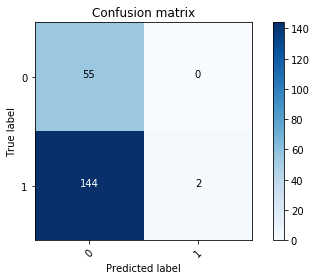

In [3]:
# Get the data
data1 = group_classes(_data, {0:0, 1:1, 2:1, 3:1})

y1 = data1['GroupID']
X1 = data1.drop(['GroupID'], axis=1)

X_train1, X_test1, Y_train1, Y_test1 = train_test_split(X1, y1, test_size=_test_size, random_state=_random_seed)

best1 = grid_search_optimization(clf, param_grid, X_train1, Y_train1, X_test1, Y_test1, cv=_cv, scoring=_scoring)

In [4]:
scores = cross_validate(best1.best_estimator_, X_train1, Y_train1, cv=_cv, return_train_score=True, scoring=_scoring_list)
for score in scores:
    print("%s\t%s\t%s" %(score, np.mean(scores[score]), np.std(scores[score])))

C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:117: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:156: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:117: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:156: RuntimeWarning: invalid value encountered in double_scalars


fit_time	0.316821813583	0.00852385445748
score_time	0.169624662399	0.00927487973464
test_recall	0.875757121439	0.214518114792
train_recall	0.896134750778	0.172014626297
test_precision	0.727033329754	0.00908275649593
train_precision	0.731180719239	0.0187950466966
test_auc	0.506969469811	0.0122666893065
train_auc	0.512630177473	0.0240915740509
test_specificity	0.138181818182	0.233577990585
train_specificity	0.129125604168	0.220097189526
test_npv	nan	nan
train_npv	nan	nan
test_accuracy	0.670627758897	0.0900297126532
train_accuracy	0.682554517134	0.062875281955
test_weighted_sensitivity	0.875757121439	0.214518114792
train_weighted_sensitivity	0.896134750778	0.172014626297
test_weighted_ppv	0.506907469295	0.0117420114881
train_weighted_ppv	0.512569807897	0.0245132336135
test_weighted_specificity	0.138181818182	0.233577990585
train_weighted_specificity	0.129125604168	0.220097189526
test_weighted_npv	nan	nan
train_weighted_npv	nan	nan
test_weighted_accuracy	0.506969469811	0.0122666893065
trai

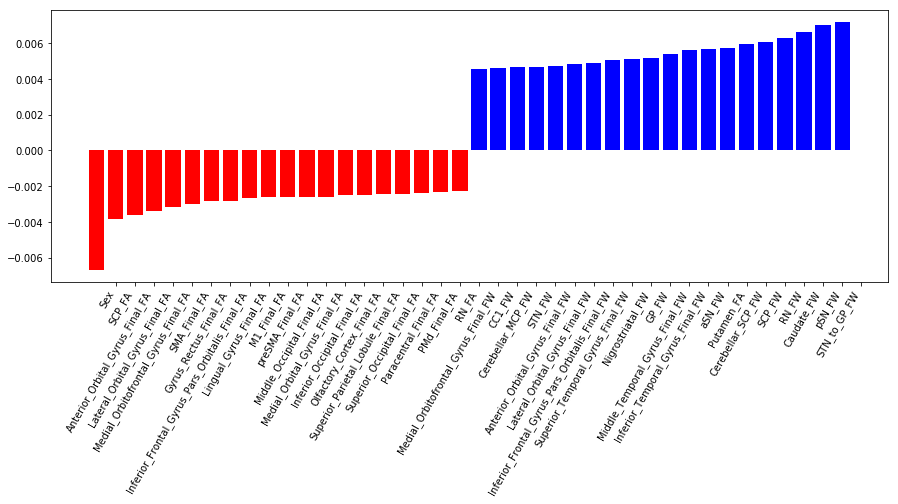

Age	0.00242744552405
Sex	-0.00666084933769
aSN_FA	0.002294792177
Caudate_FA	-0.000477539381939
CC2_FA	0.00060057528411
GP_FA	0.0013906125532
LobuleVI_FA	-0.00218351729587
LobuleV_FA	-0.0021814988356
MCP_FA	-0.00085490027534
pSN_FA	0.00446807663833
Putamen_FA	0.00571871463944
SCP_FA	-0.00384322187488
STN_FA	0.00287515751037
Thalamus_FA	0.00449967792526
Vermis_FA	0.00126441221765
RN_FA	-0.00229440259495
PPN_FA	0.00367174921959
Dentate_FA	-0.000800414292893
CC1_FA	-0.00124346778065
aSN_FW	0.00565487351868
Caudate_FW	0.00663890362741
CC2_FW	0.00386731872783
GP_FW	0.00516794596783
LobuleVI_FW	0.00263184264421
LobuleV_FW	0.00389788007524
MCP_FW	0.00362385400115
pSN_FW	0.00702082891003
Putamen_FW	0.00372634300186
SCP_FW	0.0060779617217
STN_FW	0.00469505983752
Thalamus_FW	0.00372643945029
Vermis_FW	0.000920716127342
RN_FW	0.0062823282923
PPN_FW	0.00324421230523
Dentate_FW	0.00321996027558
CC1_FW	0.00460042832241
Angular_Gyrus_Final_FA	-0.0017110175794
Anterior_Orbital_Gyrus_Final_FA	-0.0036224

In [5]:
model = best1.best_estimator_.named_steps['classifier']
feature_names = data1.columns.tolist()[1:]
plot_coefficients(model, feature_names)
print_feature_importance(feature_names, model.coef_[0])

             precision    recall  f1-score   support

        0.0       0.28      1.00      0.43        55
        1.0       1.00      0.01      0.03       146

avg / total       0.80      0.28      0.14       201



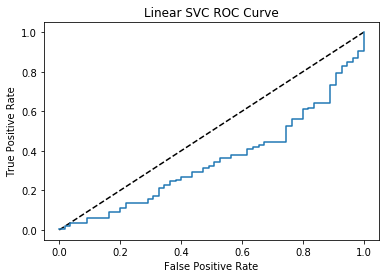

0.0 0.00684931506849
0.0181818181818 0.00684931506849
0.0181818181818 0.0205479452055
0.0363636363636 0.0205479452055
0.0363636363636 0.0342465753425
0.0909090909091 0.0342465753425
0.0909090909091 0.0616438356164
0.163636363636 0.0616438356164
0.163636363636 0.0890410958904
0.2 0.0890410958904
0.2 0.109589041096
0.218181818182 0.109589041096
0.218181818182 0.13698630137
0.290909090909 0.13698630137
0.290909090909 0.157534246575
0.309090909091 0.157534246575
0.309090909091 0.171232876712
0.327272727273 0.171232876712
0.327272727273 0.212328767123
0.345454545455 0.212328767123
0.345454545455 0.22602739726
0.363636363636 0.22602739726
0.363636363636 0.246575342466
0.381818181818 0.246575342466
0.381818181818 0.253424657534
0.4 0.253424657534
0.4 0.267123287671
0.436363636364 0.267123287671
0.436363636364 0.294520547945
0.472727272727 0.294520547945
0.472727272727 0.315068493151
0.490909090909 0.315068493151
0.490909090909 0.321917808219
0.509090909091 0.321917808219
0.509090909091 0.3424

In [6]:
plot_roc(best1.best_estimator_, X_test1, Y_test1)

## 2. PD vs MSA/PSP

# Tuning hyper-parameters for f1_micro

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   13.7s finished


Best parameters set found on development set:

{'classifier__C': 0.01438449888287663}

Detailed classification report (holdout):

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

        0.0       0.96      0.90      0.93       105
        1.0       0.78      0.90      0.84        40

avg / total       0.91      0.90      0.91       145


Confusion matrix, without normalization
[[95 10]
 [ 4 36]]

recall	0.9
precision	0.782608695652
auc	0.902380952381
specificity	0.904761904762
npv	0.959595959596
accuracy	0.903448275862
weighted_sensitivity	0.9
weighted_ppv	0.904306220096
weighted_specificity	0.904761904762
weighted_npv	0.900473933649
weighted_accuracy	0.902380952381


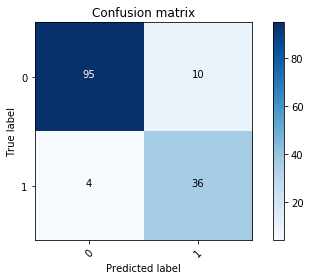

In [7]:
# Get the data
data2 = group_classes(_data, {1:0, 2:1, 3:1})

y2 = data2['GroupID']
X2 = data2.drop(['GroupID'], axis=1)

X_train2, X_test2, Y_train2, Y_test2 = train_test_split(X2, y2, test_size=_test_size, random_state=_random_seed)

best2 = grid_search_optimization(clf, param_grid, X_train2, Y_train2, X_test2, Y_test2, cv=_cv, scoring=_scoring)

In [8]:
scores = cross_validate(best2.best_estimator_, X_train2, Y_train2, cv=_cv, return_train_score=True, scoring=_scoring_list)
for score in scores:
    print("%s\t%s\t%s" %(score, np.mean(scores[score]), np.std(scores[score])))

fit_time	0.0885645389557	0.00283926801943
score_time	0.0481093883514	0.00423985381074
test_recall	0.780504201681	0.0388282582882
train_recall	0.861297049317	0.0144908257284
test_precision	0.82014692177	0.0696111751037
train_precision	0.873433760006	0.0291756647874
test_auc	0.852085885845	0.0201643645837
train_auc	0.90386314954	0.0113318716488
test_specificity	0.923667570009	0.035209757284
train_specificity	0.946429249763	0.0138400141669
test_npv	0.908328177033	0.0144420975946
train_npv	0.941214960362	0.00619246947097
test_accuracy	0.880865720986	0.0225363514654
train_accuracy	0.920985547309	0.0116982319825
test_weighted_sensitivity	0.780504201681	0.0388282582882
train_weighted_sensitivity	0.861297049317	0.0144908257284
test_weighted_ppv	0.912936430336	0.0367460336592
train_weighted_ppv	0.941582139584	0.0144589206012
test_weighted_specificity	0.923667570009	0.035209757284
train_weighted_specificity	0.946429249763	0.0138400141669
test_weighted_npv	0.80905542574	0.0269165929807
train_weig

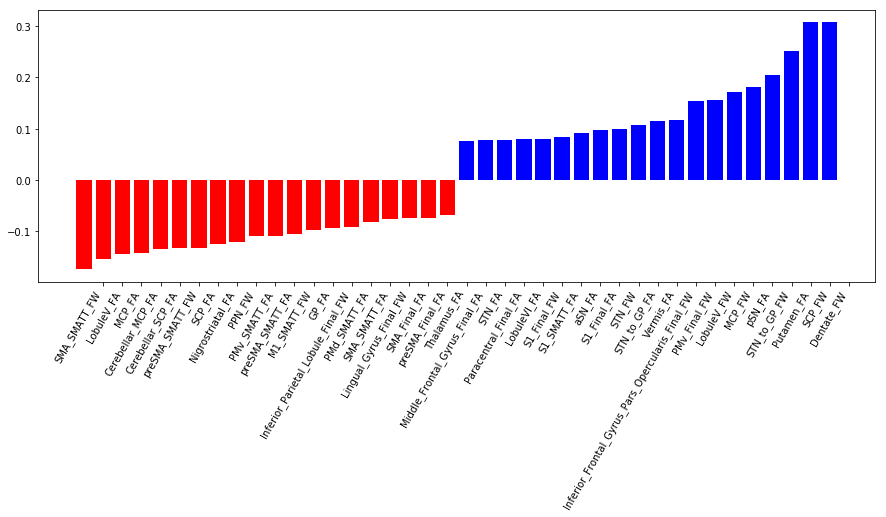

Age	-0.0157128389033
Sex	0.0
aSN_FA	0.0913224418465
Caudate_FA	-0.0075641128668
CC2_FA	0.05640621469
GP_FA	-0.0971801383641
LobuleVI_FA	0.0790904787261
LobuleV_FA	-0.153480222005
MCP_FA	-0.143568025538
pSN_FA	0.180558833155
Putamen_FA	0.252124797085
SCP_FA	-0.131481470628
STN_FA	0.077477421862
Thalamus_FA	-0.0673873769615
Vermis_FA	0.115393305701
RN_FA	-0.0526094785998
PPN_FA	0.0762403023898
Dentate_FA	0.0488112095432
CC1_FA	-0.000721862256469
aSN_FW	0.0300786911844
Caudate_FW	0.0371724931119
CC2_FW	-0.0306357476957
GP_FW	0.0531685473493
LobuleVI_FW	-0.00891025641702
LobuleV_FW	0.155423937564
MCP_FW	0.171520146328
pSN_FW	-0.000166694268869
Putamen_FW	0.00742688866558
SCP_FW	0.307339001115
STN_FW	0.0998740213397
Thalamus_FW	0.0339970708053
Vermis_FW	0.0362097717039
RN_FW	-0.0320677015734
PPN_FW	-0.120653432915
Dentate_FW	0.307570143583
CC1_FW	0.0505720455052
Angular_Gyrus_Final_FA	-0.0213269190242
Anterior_Orbital_Gyrus_Final_FA	0.0231237938076
Calcarine_Sulcus_Final_FA	-0.0161686557372

In [9]:
model = best2.best_estimator_.named_steps['classifier']
feature_names = data2.columns.tolist()[1:]
plot_coefficients(model, feature_names)
print_feature_importance(feature_names, model.coef_[0])

             precision    recall  f1-score   support

        0.0       0.96      0.90      0.93       105
        1.0       0.78      0.90      0.84        40

avg / total       0.91      0.90      0.91       145



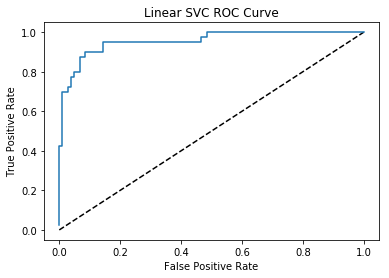

0.0 0.025
0.0 0.425
0.00952380952381 0.425
0.00952380952381 0.7
0.0285714285714 0.7
0.0285714285714 0.725
0.0380952380952 0.725
0.0380952380952 0.775
0.047619047619 0.775
0.047619047619 0.8
0.0666666666667 0.8
0.0666666666667 0.875
0.0857142857143 0.875
0.0857142857143 0.9
0.142857142857 0.9
0.142857142857 0.95
0.466666666667 0.95
0.466666666667 0.975
0.485714285714 0.975
0.485714285714 1.0
1.0 1.0


In [10]:
plot_roc(best2.best_estimator_, X_test2, Y_test2)

## 3. MSA vs PD/PSP

# Tuning hyper-parameters for f1_micro

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   13.9s finished


Best parameters set found on development set:

{'classifier__C': 0.0033598182862837811}

Detailed classification report (holdout):

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

        0.0       0.97      0.85      0.91       131
        1.0       0.34      0.71      0.47        14

avg / total       0.91      0.84      0.86       145


Confusion matrix, without normalization
[[112  19]
 [  4  10]]

recall	0.714285714286
precision	0.344827586207
auc	0.784623773173
specificity	0.854961832061
npv	0.965517241379
accuracy	0.841379310345
weighted_sensitivity	0.714285714286
weighted_ppv	0.831218274112
weighted_specificity	0.854961832061
weighted_npv	0.749521988528
weighted_accuracy	0.784623773173


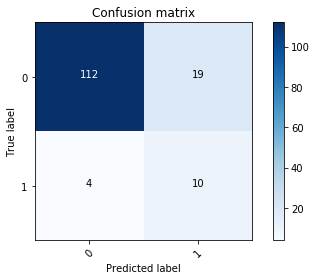

In [11]:
# Get the data
data3 = group_classes(_data, {1:0, 3:0, 2:1})

y3 = data3['GroupID']
X3 = data3.drop(['GroupID'], axis=1)

X_train3, X_test3, Y_train3, Y_test3 = train_test_split(X3, y3, test_size=_test_size, random_state=_random_seed)

best3 = grid_search_optimization(clf, param_grid, X_train3, Y_train3, X_test3, Y_test3, cv=_cv, scoring=_scoring)

In [12]:
scores = cross_validate(best3.best_estimator_, X_train3, Y_train3, cv=_cv, return_train_score=True, scoring=_scoring_list)
for score in scores:
    print("%s\t%s\t%s" %(score, np.mean(scores[score]), np.std(scores[score])))

fit_time	0.130663824081	0.0105508588797
score_time	0.0689347743988	0.00460354196803
test_recall	0.6	0.0968904283304
train_recall	0.746428571429	0.0262445329584
test_precision	0.495182595183	0.0399876940854
train_precision	0.572728523501	0.0406251155722
test_auc	0.756765676568	0.0383018255994
train_auc	0.834411110882	0.0112694896928
test_specificity	0.913531353135	0.0236294711246
train_specificity	0.922393650335	0.0135279641101
test_npv	0.943638945092	0.0117188975596
train_npv	0.963604712167	0.00339944612133
test_accuracy	0.875652173913	0.0116391857742
train_accuracy	0.901121806807	0.0106233071263
test_weighted_sensitivity	0.6	0.0968904283304
train_weighted_sensitivity	0.746428571429	0.0262445329584
test_weighted_ppv	0.875975379543	0.0174023600428
train_weighted_ppv	0.906187179912	0.0137494632875
test_weighted_specificity	0.913531353135	0.0236294711246
train_weighted_specificity	0.922393650335	0.0135279641101
test_weighted_npv	0.69973001128	0.0479009427184
train_weighted_npv	0.784814913

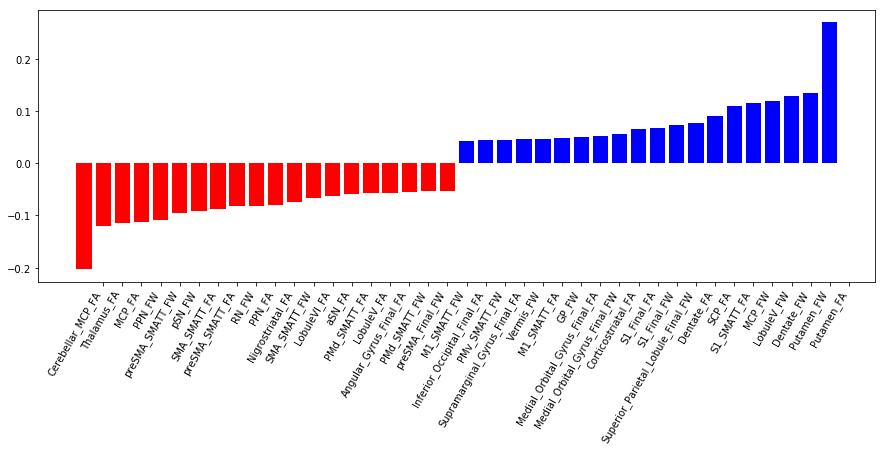

Age	0.0136457966701
Sex	0.0
aSN_FA	-0.0628212572366
Caudate_FA	-0.0250828484587
CC2_FA	0.000644243420863
GP_FA	0.0141790405163
LobuleVI_FA	-0.067517093093
LobuleV_FA	-0.0574777369682
MCP_FA	-0.115603772265
pSN_FA	-0.0175459217962
Putamen_FA	0.269847536169
SCP_FA	0.0904332277552
STN_FA	-0.0361571210033
Thalamus_FA	-0.120183001248
Vermis_FA	0.00767028608156
RN_FA	-0.0246948483046
PPN_FA	-0.0829424374198
Dentate_FA	0.0776448034853
CC1_FA	-0.0245502221891
aSN_FW	-0.0134553014435
Caudate_FW	0.0160690914716
CC2_FW	-0.0382158823177
GP_FW	0.0488433512104
LobuleVI_FW	0.00944076154131
LobuleV_FW	0.118457378895
MCP_FW	0.114729398637
pSN_FW	-0.0946135313205
Putamen_FW	0.133468990999
SCP_FW	0.018257362613
STN_FW	-0.0128879629517
Thalamus_FW	0.0374639687131
Vermis_FW	0.0465030005009
RN_FW	-0.0829582518194
PPN_FW	-0.11244679853
Dentate_FW	0.127454453708
CC1_FW	-0.0213383677729
Angular_Gyrus_Final_FA	-0.0567356071927
Anterior_Orbital_Gyrus_Final_FA	0.00651723266924
Calcarine_Sulcus_Final_FA	0.01927632

In [13]:
model = best3.best_estimator_.named_steps['classifier']
feature_names = data3.columns.tolist()[1:]
plot_coefficients(model, feature_names)
print_feature_importance(feature_names, model.coef_[0])

             precision    recall  f1-score   support

        0.0       0.97      0.85      0.91       131
        1.0       0.34      0.71      0.47        14

avg / total       0.91      0.84      0.86       145



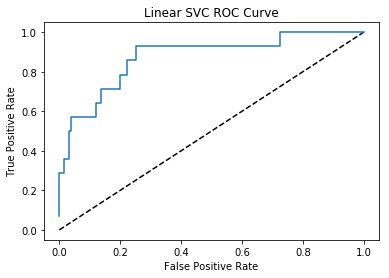

0.0 0.0714285714286
0.0 0.285714285714
0.0152671755725 0.285714285714
0.0152671755725 0.357142857143
0.030534351145 0.357142857143
0.030534351145 0.5
0.0381679389313 0.5
0.0381679389313 0.571428571429
0.12213740458 0.571428571429
0.12213740458 0.642857142857
0.137404580153 0.642857142857
0.137404580153 0.714285714286
0.198473282443 0.714285714286
0.198473282443 0.785714285714
0.221374045802 0.785714285714
0.221374045802 0.857142857143
0.251908396947 0.857142857143
0.251908396947 0.928571428571
0.725190839695 0.928571428571
0.725190839695 1.0
1.0 1.0


In [14]:
plot_roc(best3.best_estimator_, X_test3, Y_test3)

## 4. PSP vs PD/MSA

# Tuning hyper-parameters for f1_micro

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   11.8s finished


Best parameters set found on development set:

{'classifier__C': 0.01438449888287663}

Detailed classification report (holdout):

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

        0.0       0.96      0.95      0.95       119
        1.0       0.78      0.81      0.79        26

avg / total       0.93      0.92      0.92       145


Confusion matrix, without normalization
[[113   6]
 [  5  21]]

recall	0.807692307692
precision	0.777777777778
auc	0.878636069813
specificity	0.949579831933
npv	0.957627118644
accuracy	0.924137931034
weighted_sensitivity	0.807692307692
weighted_ppv	0.941242937853
weighted_specificity	0.949579831933
weighted_npv	0.83158788565
weighted_accuracy	0.878636069813


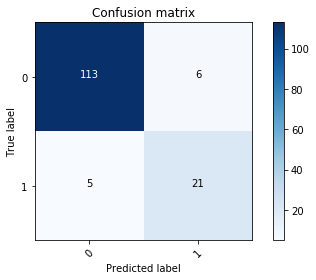

In [15]:
# Get the data
data4 = group_classes(_data, {1:0, 2:0, 3:1})

y4 = data4['GroupID']
X4 = data4.drop(['GroupID'], axis=1)

X_train4, X_test4, Y_train4, Y_test4 = train_test_split(X4, y4, test_size=_test_size, random_state=_random_seed)

best4 = grid_search_optimization(clf, param_grid, X_train4, Y_train4, X_test4, Y_test4, cv=_cv, scoring=_scoring)

In [16]:
scores = cross_validate(best4.best_estimator_, X_train4, Y_train4, cv=_cv, return_train_score=True, scoring=_scoring_list)
for score in scores:
    print("%s\t%s\t%s" %(score, np.mean(scores[score]), np.std(scores[score])))

fit_time	0.0693846702576	0.00259762664172
score_time	0.0397390842438	0.00766604613465
test_recall	0.816666666667	0.0531117847375
train_recall	0.917513958272	0.0138499282821
test_precision	0.870158730159	0.0771248917614
train_precision	0.893932106026	0.0181041225031
test_auc	0.894682017544	0.0331478276832
train_auc	0.946939048483	0.00748440980321
test_specificity	0.972697368421	0.0170875414271
train_specificity	0.976364138693	0.00440025062297
test_npv	0.960582679084	0.0120614553812
train_npv	0.982046363864	0.00302279105004
test_accuracy	0.944810799728	0.0221268125385
train_accuracy	0.965889556869	0.00460939862774
test_weighted_sensitivity	0.816666666667	0.0531117847375
train_weighted_sensitivity	0.917513958272	0.0138499282821
test_weighted_ppv	0.967101394783	0.0207420401721
train_weighted_ppv	0.974894811795	0.0045900645107
test_weighted_specificity	0.972697368421	0.0170875414271
train_weighted_specificity	0.976364138693	0.00440025062297
test_weighted_npv	0.842836021421	0.0408901164449
t

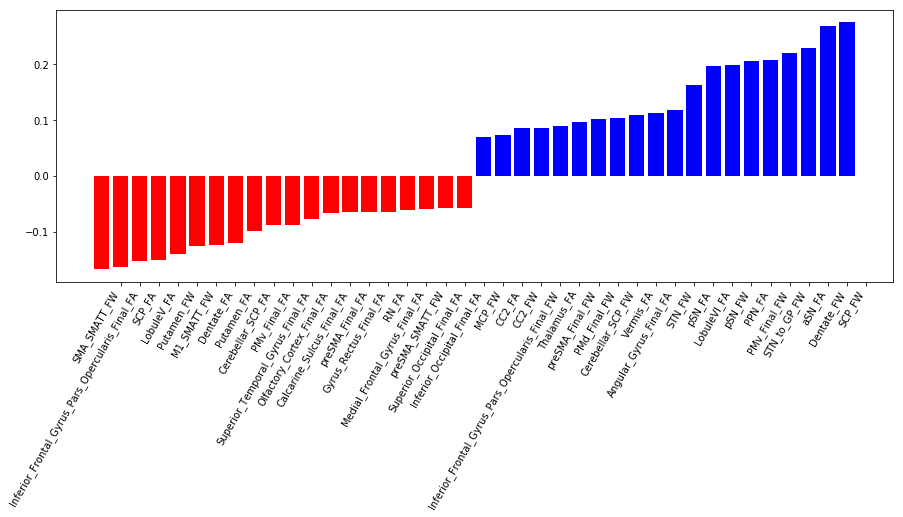

Age	0.0484997536538
Sex	0.0
aSN_FA	0.227083324532
Caudate_FA	-0.000742907185126
CC2_FA	0.0723968034842
GP_FA	-0.0507019698764
LobuleVI_FA	0.195000764038
LobuleV_FA	-0.150167753171
MCP_FA	0.042814391084
pSN_FA	0.161170924169
Putamen_FA	-0.12005972199
SCP_FA	-0.151898728473
STN_FA	0.0557009020012
Thalamus_FA	0.0892121338105
Vermis_FA	0.10880495339
RN_FA	-0.0647599526172
PPN_FA	0.204768671732
Dentate_FA	-0.124318797456
CC1_FA	0.0205969910161
aSN_FW	0.0341363613049
Caudate_FW	0.0244396836425
CC2_FW	0.0846433883867
GP_FW	-0.0560074172844
LobuleVI_FW	-0.0335907560896
LobuleV_FW	-0.0190213043679
MCP_FW	0.0686942496771
pSN_FW	0.196943705543
Putamen_FW	-0.1406277388
SCP_FW	0.274142361514
STN_FW	0.11784706164
Thalamus_FW	0.028837580262
Vermis_FW	0.00500246838961
RN_FW	0.0280225151315
PPN_FW	0.0200515645147
Dentate_FW	0.26771294246
CC1_FW	0.00270199634006
Angular_Gyrus_Final_FA	0.111997447941
Anterior_Orbital_Gyrus_Final_FA	0.0377878964271
Calcarine_Sulcus_Final_FA	-0.0675802160327
Cuneus_Final_F

In [17]:
model = best4.best_estimator_.named_steps['classifier']
feature_names = data4.columns.tolist()[1:]
plot_coefficients(model, feature_names)
print_feature_importance(feature_names, model.coef_[0])

             precision    recall  f1-score   support

        0.0       0.96      0.95      0.95       119
        1.0       0.78      0.81      0.79        26

avg / total       0.93      0.92      0.92       145



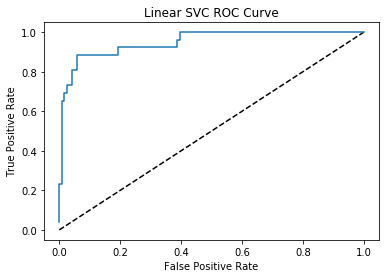

0.0 0.0384615384615
0.0 0.230769230769
0.00840336134454 0.230769230769
0.00840336134454 0.653846153846
0.0168067226891 0.653846153846
0.0168067226891 0.692307692308
0.0252100840336 0.692307692308
0.0252100840336 0.730769230769
0.0420168067227 0.730769230769
0.0420168067227 0.807692307692
0.0588235294118 0.807692307692
0.0588235294118 0.884615384615
0.193277310924 0.884615384615
0.193277310924 0.923076923077
0.386554621849 0.923076923077
0.386554621849 0.961538461538
0.394957983193 0.961538461538
0.394957983193 1.0
1.0 1.0


In [18]:
plot_roc(best4.best_estimator_, X_test4, Y_test4)

## 5. PSP (positive) vs MSA (negative)

# Tuning hyper-parameters for f1_micro

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done  85 out of 100 | elapsed:    9.5s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    9.7s finished


Best parameters set found on development set:

{'classifier__C': 0.01438449888287663}

Detailed classification report (holdout):

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

        0.0       0.71      0.77      0.74        13
        1.0       0.90      0.87      0.88        30

avg / total       0.84      0.84      0.84        43


Confusion matrix, without normalization
[[10  3]
 [ 4 26]]

recall	0.866666666667
precision	0.896551724138
auc	0.817948717949
specificity	0.769230769231
npv	0.714285714286
accuracy	0.837209302326
weighted_sensitivity	0.866666666667
weighted_ppv	0.789719626168
weighted_specificity	0.769230769231
weighted_npv	0.852272727273
weighted_accuracy	0.817948717949


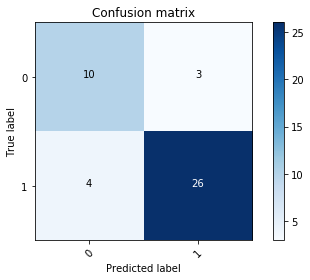

In [19]:
# Get the data
data5 = group_classes(_data, {2:0, 3:1})

y5 = data5['GroupID']
X5 = data5.drop(['GroupID'], axis=1)

X_train5, X_test5, Y_train5, Y_test5 = train_test_split(X5, y5, test_size=_test_size, random_state=_random_seed)

best5 = grid_search_optimization(clf, param_grid, X_train5, Y_train5, X_test5, Y_test5, cv=_cv, scoring=_scoring)

In [20]:
scores = cross_validate(best5.best_estimator_, X_train5, Y_train5, cv=_cv, return_train_score=True, scoring=_scoring_list)
for score in scores:
    print("%s\t%s\t%s" %(score, np.mean(scores[score]), np.std(scores[score])))

fit_time	0.0117995262146	0.00147088486955
score_time	0.0139068126678	0.00379000951098
test_recall	0.838947368421	0.0726506458574
train_recall	0.868639240506	0.0250140963303
test_precision	0.892084623323	0.0478124080463
train_precision	0.963684407096	0.0105473806589
test_auc	0.848521303258	0.0592701705933
train_auc	0.911449946068	0.0147717323098
test_specificity	0.858095238095	0.0649716491459
train_specificity	0.954260651629	0.0139430386423
test_npv	0.796240573152	0.0820284548142
train_npv	0.839761509442	0.0246528126105
test_accuracy	0.846671759613	0.0604853132473
train_accuracy	0.904431483867	0.0160050008251
test_weighted_sensitivity	0.838947368421	0.0726506458574
train_weighted_sensitivity	0.868639240506	0.0250140963303
test_weighted_ppv	0.856412501958	0.0622780610468
train_weighted_ppv	0.95011983536	0.0143531291526
test_weighted_specificity	0.858095238095	0.0649716491459
train_weighted_specificity	0.954260651629	0.0139430386423
test_weighted_npv	0.844134872471	0.0641219421202
train_w

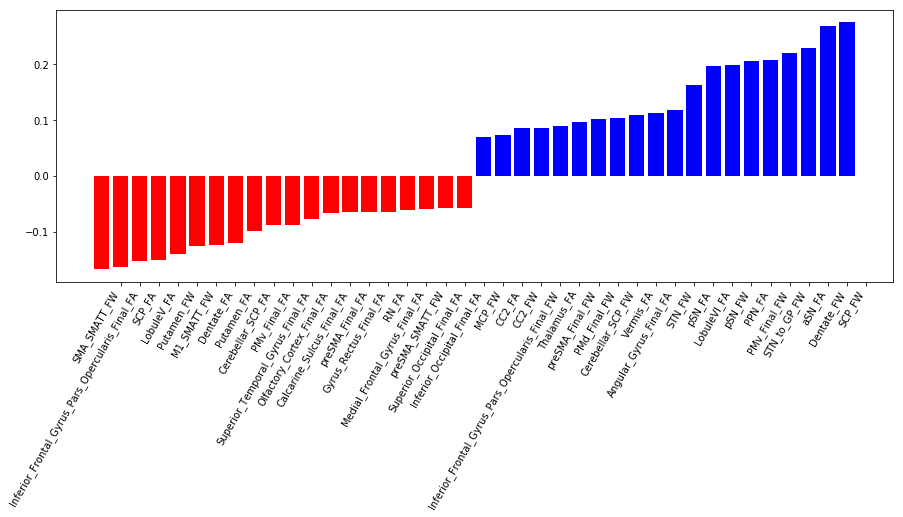

Age	0.0484997536538
Sex	0.0
aSN_FA	0.227083324532
Caudate_FA	-0.000742907185126
CC2_FA	0.0723968034842
GP_FA	-0.0507019698764
LobuleVI_FA	0.195000764038
LobuleV_FA	-0.150167753171
MCP_FA	0.042814391084
pSN_FA	0.161170924169
Putamen_FA	-0.12005972199
SCP_FA	-0.151898728473
STN_FA	0.0557009020012
Thalamus_FA	0.0892121338105
Vermis_FA	0.10880495339
RN_FA	-0.0647599526172
PPN_FA	0.204768671732
Dentate_FA	-0.124318797456
CC1_FA	0.0205969910161
aSN_FW	0.0341363613049
Caudate_FW	0.0244396836425
CC2_FW	0.0846433883867
GP_FW	-0.0560074172844
LobuleVI_FW	-0.0335907560896
LobuleV_FW	-0.0190213043679
MCP_FW	0.0686942496771
pSN_FW	0.196943705543
Putamen_FW	-0.1406277388
SCP_FW	0.274142361514
STN_FW	0.11784706164
Thalamus_FW	0.028837580262
Vermis_FW	0.00500246838961
RN_FW	0.0280225151315
PPN_FW	0.0200515645147
Dentate_FW	0.26771294246
CC1_FW	0.00270199634006
Angular_Gyrus_Final_FA	0.111997447941
Anterior_Orbital_Gyrus_Final_FA	0.0377878964271
Calcarine_Sulcus_Final_FA	-0.0675802160327
Cuneus_Final_F

In [21]:
model = best4.best_estimator_.named_steps['classifier']
feature_names = data4.columns.tolist()[1:]
plot_coefficients(model, feature_names)
print_feature_importance(feature_names, model.coef_[0])

             precision    recall  f1-score   support

        0.0       0.71      0.77      0.74        13
        1.0       0.90      0.87      0.88        30

avg / total       0.84      0.84      0.84        43



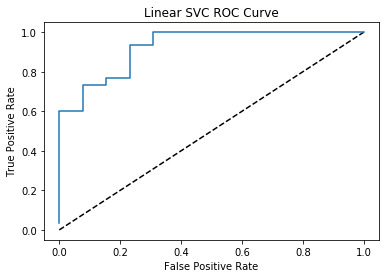

0.0 0.0333333333333
0.0 0.6
0.0769230769231 0.6
0.0769230769231 0.733333333333
0.153846153846 0.733333333333
0.153846153846 0.766666666667
0.230769230769 0.766666666667
0.230769230769 0.933333333333
0.307692307692 0.933333333333
0.307692307692 1.0
1.0 1.0


In [22]:
plot_roc(best5.best_estimator_, X_test5, Y_test5)

## 6. MSA (positive) vs PSP (negative)

# Tuning hyper-parameters for f1_micro

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done  85 out of 100 | elapsed:    8.8s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    8.9s finished


Best parameters set found on development set:

{'classifier__C': 0.01438449888287663}

Detailed classification report (holdout):

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

        0.0       0.90      0.87      0.88        30
        1.0       0.71      0.77      0.74        13

avg / total       0.84      0.84      0.84        43


Confusion matrix, without normalization
[[26  4]
 [ 3 10]]

recall	0.769230769231
precision	0.714285714286
auc	0.817948717949
specificity	0.866666666667
npv	0.896551724138
accuracy	0.837209302326
weighted_sensitivity	0.769230769231
weighted_ppv	0.852272727273
weighted_specificity	0.866666666667
weighted_npv	0.789719626168
weighted_accuracy	0.817948717949


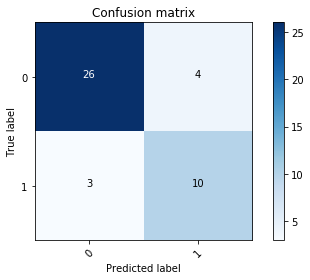

In [23]:
# Get the data
data6 = group_classes(_data, {2:1, 3:0})

y6 = data6['GroupID']
X6 = data6.drop(['GroupID'], axis=1)

X_train6, X_test6, Y_train6, Y_test6 = train_test_split(X6, y6, test_size=_test_size, random_state=_random_seed)

best6 = grid_search_optimization(clf, param_grid, X_train6, Y_train6, X_test6, Y_test6, cv=_cv, scoring=_scoring)

In [24]:
scores = cross_validate(best4.best_estimator_, X_train6, Y_train6, cv=_cv, return_train_score=True, scoring=_scoring_list)
for score in scores:
    print("%s\t%s\t%s" %(score, np.mean(scores[score]), np.std(scores[score])))

fit_time	0.0116395950317	0.00165268247378
score_time	0.0126862049103	0.000881032100384
test_recall	0.858095238095	0.0649716491459
train_recall	0.954260651629	0.0139430386423
test_precision	0.796240573152	0.0820284548142
train_precision	0.839761509442	0.0246528126105
test_auc	0.848521303258	0.0592701705933
train_auc	0.911449946068	0.0147717323098
test_specificity	0.838947368421	0.0726506458574
train_specificity	0.868639240506	0.0250140963303
test_npv	0.892084623323	0.0478124080463
train_npv	0.963684407096	0.0105473806589
test_accuracy	0.846671759613	0.0604853132473
train_accuracy	0.904431483867	0.0160050008251
test_weighted_sensitivity	0.858095238095	0.0649716491459
train_weighted_sensitivity	0.954260651629	0.0139430386423
test_weighted_ppv	0.844134872471	0.0641219421202
train_weighted_ppv	0.879423929019	0.0200337589256
test_weighted_specificity	0.838947368421	0.0726506458574
train_weighted_specificity	0.868639240506	0.0250140963303
test_weighted_npv	0.856412501958	0.0622780610468
train

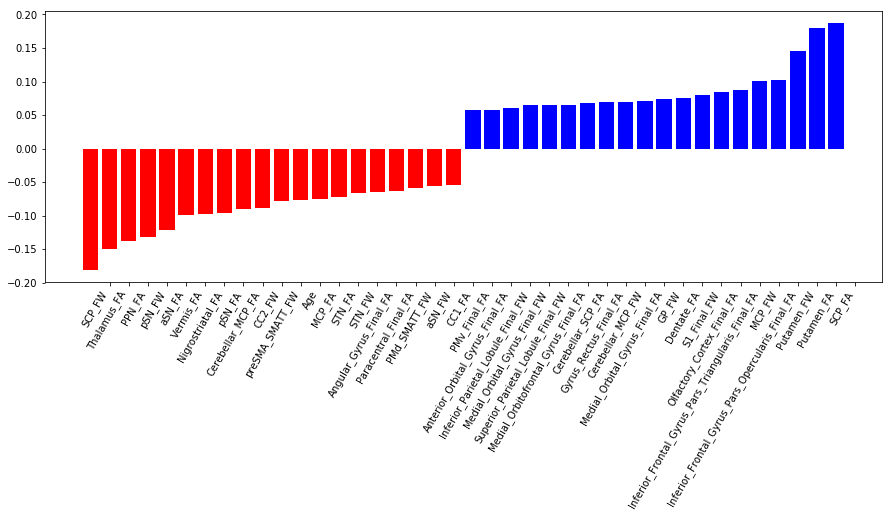

Age	-0.0762711786424
Sex	-0.0285537993012
aSN_FA	-0.121531014452
Caudate_FA	-0.0140960752737
CC2_FA	-0.0219530069555
GP_FA	0.0243216371045
LobuleVI_FA	-0.0505398831163
LobuleV_FA	0.0518825434615
MCP_FA	-0.0750181298434
pSN_FA	-0.0963781552945
Putamen_FA	0.18030770868
SCP_FA	0.187374017272
STN_FA	-0.0716912383312
Thalamus_FA	-0.15049514606
Vermis_FA	-0.0988966840541
RN_FA	0.0172331397306
PPN_FA	-0.138339538355
Dentate_FA	0.0757487307878
CC1_FA	-0.0546782776128
aSN_FW	-0.0565464200637
Caudate_FW	0.0104535471016
CC2_FW	-0.0887519151433
GP_FW	0.0733307269503
LobuleVI_FW	0.0123709855259
LobuleV_FW	0.0283790010115
MCP_FW	0.10057505347
pSN_FW	-0.132004271892
Putamen_FW	0.14547219721
SCP_FW	-0.181177531005
STN_FW	-0.0668286993803
Thalamus_FW	-0.0220822083985
Vermis_FW	0.00601272249054
RN_FW	-0.0495532015031
PPN_FW	-0.0448548528881
Dentate_FW	0.0435930425444
CC1_FW	-0.0140846183421
Angular_Gyrus_Final_FA	-0.064549986459
Anterior_Orbital_Gyrus_Final_FA	0.0575426096076
Calcarine_Sulcus_Final_FA	0

In [25]:
model = best6.best_estimator_.named_steps['classifier']
feature_names = data6.columns.tolist()[1:]
plot_coefficients(model, feature_names)
print_feature_importance(feature_names, model.coef_[0])

             precision    recall  f1-score   support

        0.0       0.90      0.87      0.88        30
        1.0       0.71      0.77      0.74        13

avg / total       0.84      0.84      0.84        43



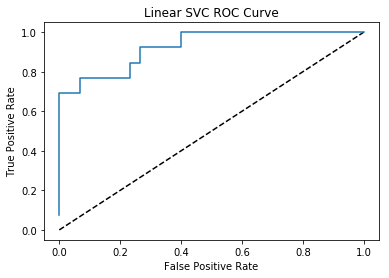

0.0 0.0769230769231
0.0 0.692307692308
0.0666666666667 0.692307692308
0.0666666666667 0.769230769231
0.233333333333 0.769230769231
0.233333333333 0.846153846154
0.266666666667 0.846153846154
0.266666666667 0.923076923077
0.4 0.923076923077
0.4 1.0
1.0 1.0


In [26]:
plot_roc(best6.best_estimator_, X_test6, Y_test6)